In [1]:
from mesmerize import Transmission
from mesmerize.analysis.math.emd import emd_1d
from mesmerize.analysis.utils import get_proportions
from mesmerize.analysis.clustering_metrics import davies_bouldin_score as davies_bouldin_score_emd
from mesmerize.plotting.utils import get_colormap, map_labels_to_colors, auto_colormap

from scipy.cluster.hierarchy import linkage, fcluster, leaves_list
from scipy.spatial.distance import squareform

from sklearn.metrics import pairwise_distances, davies_bouldin_score, silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt
from matplotlib.patches import Patch as MPatch
from matplotlib import gridspec

import seaborn as sns
import numpy as np
import pandas as pd
from typing import *
from tqdm import tqdm
from collections import OrderedDict
import json
from pprint import pprint
from itertools import product
import json

2021-09-26 23:57:33.826102: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
/home/kushal/repos/MESmerize/mesmerize/common/configuration.py:58: UserWarning: tslearn package not found. tslearn features will be disabled.
  warn(


Useful functions

In [2]:
def get_sampling_rate(transmission, tolerance: Optional[float] = 0.1) -> float:
    """
    Returns the mean sampling rate of all data in a Transmission if it is within the specified tolerance. Otherwise throws an exception.
    :param transmission:    Transmission object of the data from which sampling rate is obtained.
    :param tolerance:       Maximum tolerance (in Hertz) of sampling rate variation between different samples
    :type tolerance:        float
    :return:                The mean sampling rate of all data in the Transmission
    :rtype:                 float
    """
    sampling_rates = []
    for db in transmission.history_trace.data_blocks:
        if transmission.history_trace.check_operation_exists(db, 'resample'):
            sampling_rates.append(transmission.history_trace.get_operation_params(db, 'resample')['output_rate'])
        else:
            r = pd.DataFrame(transmission.get_data_block_dataframe(db).meta.to_list())['fps'].unique()
            # if rates.size > 1:
            #     raise ValueError("Sampling rates for the data do not match")
            # else:
            sampling_rates.append(r)

    rates = np.hstack([sampling_rates])

    if np.ptp(rates) > tolerance:
        raise ValueError("Sampling rates of the data differ by "
                         "greater than the set tolerance of " + str(tolerance) + " Hz")

    framerate = float(np.mean(sampling_rates))

    return framerate


# Adapted from the navis package:
# https://github.com/schlegelp/navis/blob/d1da4666464988f60a056bc767bfcc3ef943ef43/navis/clustering/cluster.py#L683
def calc_agg_coeff(lkg: np.ndarray) -> float:
    """
    Calculate the agglomerative coefficient.

    This measures the clustering structure of the linkage matrix. Because
    it grows with the number of observations, this measure should not be
    used to compare datasets of very different sizes.

    For each observation i, denote by m(i) its dissimilarity to the first
    cluster it is merged with, divided by the dissimilarity of the merger
    in the final step of the algorithm. The agglomerative coefficient is
    the average of all 1 - m(i).
    
    Parameters
    ----------
    lkg: np.ndarray
        Linkage matrix returned from scipy.cluster.hierarchy.linkage
    
    Returns
    -------
    float
        Agglomerative Coefficient
    
    """
    # Turn into pandas DataFrame for fancy indexing
    Z = pd.DataFrame(lkg, columns=['obs1', 'obs2', 'dist', 'n_org'])
    
    leaves = leaves_list(lkg)

    # Get all distances at which an original observation is merged
    all_dist = Z[(Z.obs1.isin(leaves)) | (Z.obs2.isin(leaves))].dist.values

    # Divide all distances by last merger
    all_dist /= lkg[-1][2]

    # Calc final coefficient
    coeff = np.mean(1 - all_dist)

    return coeff

In [3]:
t = Transmission.from_hdf5('/home/kushal/Sars_stuff/hier_all_promoters.ptrn')

Get the time domain & freq domain data

In [4]:
# time domain
tdata = np.vstack(t.df._NORMALIZE.values)

# freq domain
fdata = np.vstack(t.df._SPLICE_ARRAYS.values)

# EMD can't be computed using negative weights
fdata += np.abs(fdata.min())

Create distance matrices

In [5]:
# dm_fdata = pairwise_distances(X, metric=emd_1d, n_jobs=22)

# precomputed EMD distance matrix
dm_emd_fdata = squareform(np.load('/home/kushal/Sars_stuff/cell_types_dm_1000.npy'), checks=False)

In [6]:
# sanity check
check = list(range(t.df.index.size)) == list(t.df.index)
if not check:
    raise ValueError

In [7]:
non_neuronal_indices = t.df[t.df.cell_name.isin(['cesa-pos', 'hnk1-pos', 'ependymal'])].index.to_list()
df_neuronal = t.df[~t.df.cell_name.isin(['cesa-pos', 'hnk1-pos', 'ependymal'])].reset_index(drop=True)

In [8]:
check = list(range(df_neuronal.index.size)) == list(df_neuronal.index)
if not check:
    raise ValueError

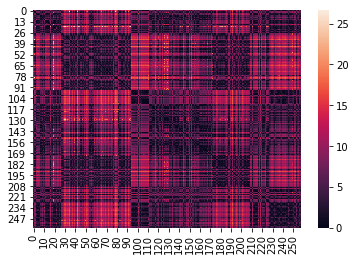

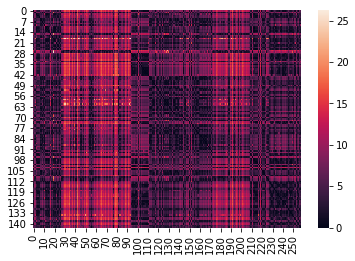

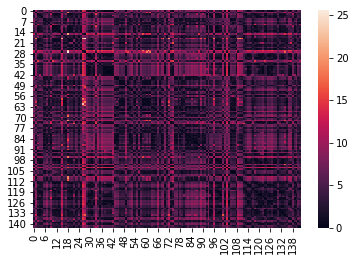

In [9]:
dm_emd_fdata_sf = squareform(dm_emd_fdata)

sns.heatmap(dm_emd_fdata_sf)
plt.show()

neuronal_dm_emd_fdata_sf = np.delete(dm_emd_fdata_sf, non_neuronal_indices, axis=0)
sns.heatmap(neuronal_dm_emd_fdata_sf)
plt.show()

neuronal_dm_emd_fdata_sf = np.delete(neuronal_dm_emd_fdata_sf, non_neuronal_indices, axis=1)
sns.heatmap(neuronal_dm_emd_fdata_sf)
plt.show()

In [10]:
# euclidean distance matrix from frequency-domain data
dm_euc_fdata = squareform(pairwise_distances(fdata), checks=False)

# euclidean distance matrix from time-domain data
dm_euc_tdata = squareform(pairwise_distances(tdata), checks=False)

Compute linkage for each distance matrix

In [11]:
lk_emd_fdata = linkage(dm_emd_fdata, method='complete', optimal_ordering=True)

lk_euc_fdata = linkage(dm_euc_fdata, method='complete', optimal_ordering=True)

lk_euc_tdata = linkage(dm_euc_tdata, method='complete', optimal_ordering=True)

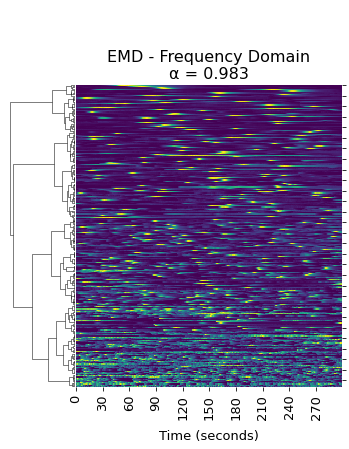

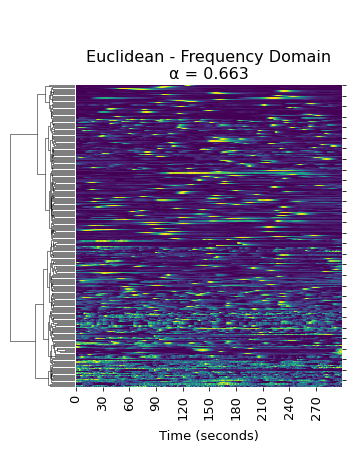

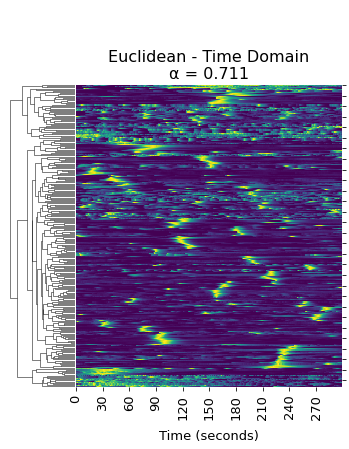

In [12]:
# For calculating xtick labels
frames_length = tdata.shape[1]
sampling_rate = get_sampling_rate(t)

# Show xticks at 30 sec intervals
xticks_interval = 30

# Recording time in seconds
recording_time = int(frames_length / sampling_rate)

dms = [lk_emd_fdata, lk_euc_fdata, lk_euc_tdata]
titles = \
[
    f"EMD - Frequency Domain\nα = {calc_agg_coeff(lk_emd_fdata):.3f}",
    f"Euclidean - Frequency Domain\nα = {calc_agg_coeff(lk_euc_fdata):.3f}",
    f"Euclidean - Time Domain\nα = {calc_agg_coeff(lk_euc_tdata):.3f}"
]

for Z, title in zip(dms, titles):
    clustermap = sns.clustermap(tdata, row_linkage=Z, row_cluster=True, col_cluster=False, cmap='viridis', figsize=(6, 7))
    
    clustermap.ax_heatmap.set_title(title, fontdict={'fontsize': 16})
    
    clustermap.ax_heatmap.set_xticks(np.arange(0, frames_length, xticks_interval * sampling_rate))
    clustermap.ax_heatmap.set_xticklabels(np.arange(0, recording_time, xticks_interval), fontdict={'fontsize': 13})
    
    clustermap.ax_heatmap.tick_params(labelright=False)
    
#     ytl = clustermap.ax_heatmap.get_yticklabels()
#     clustermap.ax_heatmap.set_yticklabels(ytl, fontdict={'fontsize': 0})
    
    clustermap.ax_heatmap.set_xlabel('Time (seconds)', fontdict={'fontsize': 13}, labelpad=10)
    
    clustermap.cax.set_visible(False)
    
    clustermap.savefig(
        f'/home/kushal/Sars_stuff/Dropbox/fig_data/compare_emd_euc_full_data/{title[:17]}.png', 
        dpi=600, 
        pad_inches=0, 
        bbox_inches='tight'
    )


In [21]:
# set the abbreviations accoridng to the Ryan et. al. paper
cell_name_abr = json.load(open('./abbreviations.json', 'r'))
t.df.cell_name = t.df.cell_name.apply(cell_name_abr.get)

# Fig 5a
# EMD Clustering in detail, 4 clusters at maxima of Silh score

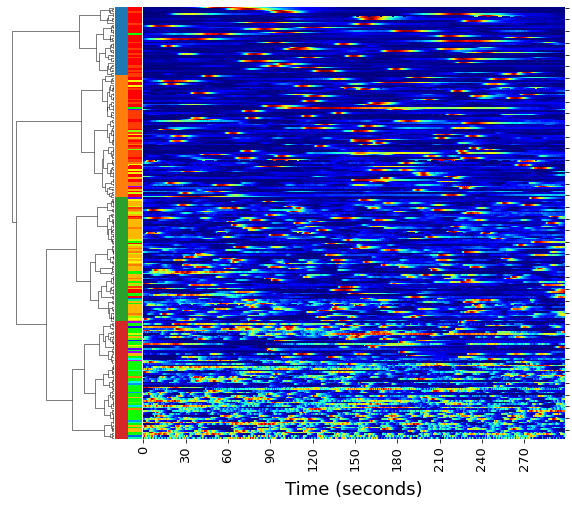

In [14]:
Z = linkage(dm_emd_fdata, method='complete', optimal_ordering=True)
labels = fcluster(Z, t=4, criterion='maxclust')

t.df['FCLUSTER_LABELS'] = labels

sort_ixs = np.argsort(labels)

cmap_cluster = get_colormap(labels, 'tab10')
colors_cluster = map(cmap_cluster.get, labels)

cmap_cell_type = get_colormap(cell_name_abr.values(), 'hsv')
colors_cell_type = map(cmap_cell_type.get, t.df.cell_name.values)

cfig = sns.clustermap(tdata, row_colors=[colors_cluster, colors_cell_type], row_linkage=Z, col_cluster=False, cmap='jet')

# legend
cfig.ax_col_dendrogram.cla()
handles = \
    [MPatch(color=cmap_cell_type[k], label=k) for k in cmap_cell_type.keys()] + \
    [MPatch(color=cmap_cluster[k], label=k) for k in cmap_cluster.keys()]

cfig.ax_col_dendrogram.legend(handles=handles, ncol=6, prop={"size": 15, "weight": "bold"})
cfig.ax_col_dendrogram.get_xaxis().set_visible(False)
cfig.ax_col_dendrogram.get_yaxis().set_visible(False)

cfig.ax_heatmap.set_xticks(np.arange(0, frames_length, xticks_interval * sampling_rate))
cfig.ax_heatmap.set_xticklabels(np.arange(0, recording_time, xticks_interval), fontdict={'fontsize': 13})

cfig.ax_heatmap.tick_params(labelright=False)

cfig.ax_heatmap.set_xlabel('Time (seconds)', fontdict={'fontsize': 18}, labelpad=10)

cfig.ax_heatmap.set_visible(False)
cfig.ax_row_dendrogram.set_visible(False)
cfig.ax_row_colors.set_visible(False)
cfig.cax.set_visible(False)

# cfig.savefig('/home/kushal/Sars_stuff/Dropbox/fig_data/hier_ciona_neuronal_detailed/hier_all_legend.png', dpi=600, pad_inches=0, bbox_inches='tight')

cfig.ax_col_dendrogram.set_visible(False)
cfig.ax_heatmap.set_visible(True)
cfig.ax_row_dendrogram.set_visible(True)
cfig.ax_row_colors.set_visible(True)

# cfig.savefig('/home/kushal/Sars_stuff/Dropbox/fig_data/hier_ciona_neuronal_detailed/hier_all.png', dpi=600, pad_inches=0, bbox_inches='tight')

# Suppl fig
# Proportions to summarize the above clustering

In [15]:
props_df = get_proportions(
    xs=t.df.cell_name,
    ys=t.df.FCLUSTER_LABELS, 
    xs_name='Cell Identity', 
    ys_name='Cluster'
)

In [16]:
props_df.fillna(value=0, inplace=True)

In [17]:
# props_df.drop(['cor_ass_bvin', 'dcen', 'mn', 'pr_amg', 'vac_in', 'ependymal'], axis='index', inplace=True)

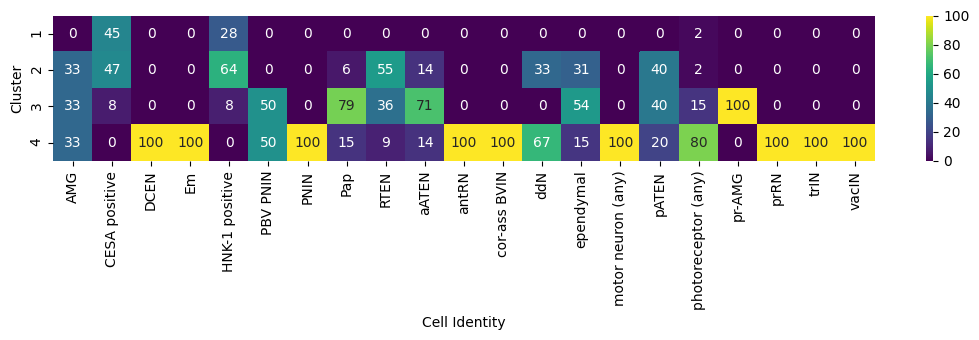

In [27]:
fig = plt.figure(figsize=(11,3.5), dpi=100)
sns.heatmap(props_df.T, cmap='viridis', annot=True, fmt="0.0f")
plt.tight_layout()

fig.savefig('/home/kushal/Sars_stuff/Dropbox/fig_data/hier_ciona_neuronal_detailed/hier_all_props.png', dpi=600, pad_inches=0, bbox_inches='tight')

In [28]:
Z = linkage(props_df, optimal_ordering=True, method='complete', metric='euclidean')

# Suppl fig
# Hierarchical clustering of cell types using proportions data

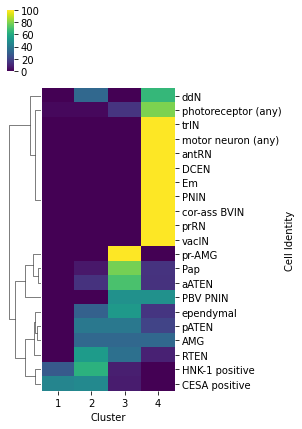

In [29]:

cm = sns.clustermap(data=props_df, row_linkage=Z, col_cluster=False, cmap='viridis', figsize=(3,7))
cm.ax_heatmap.set_ylabel("Cell Identity")
cm.ax_heatmap.set_xlabel("Cluster")

cm.savefig('/home/kushal/Sars_stuff/Dropbox/fig_data/hier_ciona_neuronal_detailed/hier_all_props_hier.png', dpi=600, pad_inches=0, bbox_inches='tight')

In [31]:
# Centerlike function from mesmerize
def get_centerlike(cluster_members: np.ndarray, 
                   metric: Optional[Union[str, callable]] = None,
                   dist_matrix: Optional[np.ndarray] = None, 
                   n_jobs: int = 16
                  ) -> Tuple[np.ndarray, int]:
    """
    Finds the 1D time-series within a cluster that is the most centerlike

    :param cluster_members: 2D numpy array in the form [n_samples, 1D time_series]
    :param metric:          Metric to use for pairwise distance calculation, simply passed to sklearn.metrics.pairwise_distances
    :param dist_matrix:     Distance matrix of the cluster members

    :return:                The cluster member which is most centerlike, and its index in the cluster_members array
    """
    if dist_matrix is None:
        dist_matrix = pairwise_distances(cluster_members, metric=metric, n_jobs=n_jobs)

    c_ix = np.argmin(np.sum(dist_matrix, axis=0))
    c = cluster_members[c_ix, :]
    return c, c_ix

Or recompute the centerlikes by setting the following cell to "code" instead of "raw"

100%|██████████| 4/4 [00:00<00:00, 560.16it/s]


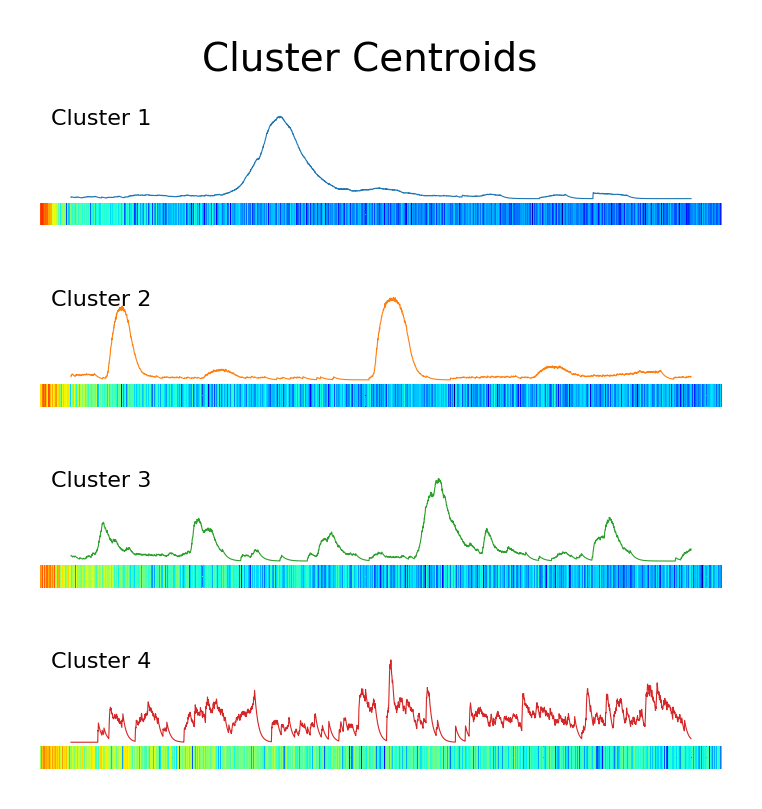

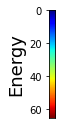

In [133]:
cluster_labels = t.df.FCLUSTER_LABELS.unique()
cluster_labels.sort()

center_likes = dict.fromkeys(cluster_labels)
center_like_dfts = dict.fromkeys(cluster_labels)

# Get the frequency domain data
rdata = np.vstack(t.df._SPLICE_ARRAYS.values)
# EMD cannot be calculated using negative weights
rdata += np.abs(rdata.min())
t.df['_ADD_MIN'] = rdata.tolist()
t.df['_ADD_MIN'] = t.df['_ADD_MIN'].apply(np.array)

# Get center-likes for each cluster
for label in tqdm(cluster_labels):
    del_ixs = t.df[t.df.FCLUSTER_LABELS != label].index.to_list()
    
    memb_dm = np.delete(dm_emd_fdata_sf, del_ixs, axis=0)
    
    memb_dm = np.delete(memb_dm, del_ixs, axis=1)
    
    # sanity check
#     sns.heatmap(neuronal_dm_emd_fdata_sf)
#     plt.show()
#     sns.heatmap(memb_dm)
#     plt.show()
#     sns.heatmap(memb_dm)
#     plt.show()
    
    # Cluster members, freq domain data
    membs = np.vstack(t.df._ADD_MIN[t.df.FCLUSTER_LABELS == label].values)
    
    # Cluster members, time domain data
    curves = np.vstack(t.df._NORMALIZE[t.df.FCLUSTER_LABELS == label].values)
    
    # Get the index of the centerlike within the cluster
    ix = get_centerlike(membs, metric=emd_1d, dist_matrix=memb_dm, n_jobs=22)[1] # Adjust n_jobs if you have more threads available
    
    # Get the centerlikes in the time and frequency domains
    center_likes[label] = curves[ix]
    center_like_dfts[label] = membs[ix]
    
# Draw the centerlikes with the time-domain plotted as trace over a band illustrating the frequency domain of the same data.
nrows = (4 * 10) + 4
ncols = 1

fig = plt.figure(figsize=(2.2, 3.3), dpi=400)
gs = gridspec.GridSpec(nrows, ncols)
gs.update(wspace=0.15, hspace=0.0)
axs = []

plot_ixs = range(8)

cmap = auto_colormap(n_colors=10, cmap='tab10')

for k in center_like_dfts.keys():
    center_like_dfts[k] = (np.abs(center_like_dfts[k]))**2
    
min_energy = np.concatenate(list(center_like_dfts.values())).min()
max_energy = np.concatenate(list(center_like_dfts.values())).max()

cluster_label = 0
for i in plot_ixs:
    if i % 2 == 0:
        ax = fig.add_subplot(gs[4*i:4*i+4])
        ax.plot(center_likes[cluster_label + 1], c=cmap[cluster_label], linewidth=0.2)
        ax.axis('off')
        ax.set_title(f'Cluster {cluster_label + 1}', fontdict={'fontsize': 4}, y=0.50, x=0.09)
        cluster_label += 1
    else:
        ax = fig.add_subplot(gs[4*i:4*i+1])
        a = center_like_dfts[cluster_label]
        hm = sns.heatmap(
            np.array([a, a]), 
            cmap='jet', 
            ax=ax, 
            cbar=False, 
            vmin=min_energy, 
            vmax=max_energy
        )
        ax.axis('off')

fig.suptitle("Cluster Centroids", fontsize=7, y=0.935)

fig_colorbar = plt.figure(figsize=(2.5, 2))
ax_cb = fig_colorbar.add_subplot(111)
a = (np.arange(min_energy, max_energy),)*4
a = np.array(a).T[::-1]
ax_cb.imshow(a, cmap='jet_r')
ax_cb.get_xaxis().set_visible(False)
ax_cb.set_ylabel("Energy", fontdict=dict(size=18))
        
fig.savefig('/home/kushal/Sars_stuff/Dropbox/fig_data/hier_ciona_neuronal_detailed/centroids_hier_all.png', dpi=600, bbox_inches='tight', pad_inches=0)
fig_colorbar.savefig('/home/kushal/Sars_stuff/Dropbox/fig_data/hier_ciona_neuronal_detailed/centroids_hier_all_cbar_legend.png', dpi=600, bbox_inches='tight', pad_inches=0)

# Example traces from each cluster

In [56]:
choices = OrderedDict.fromkeys(cluster_labels)

curves = []
cluster_numbers = []
for label in tqdm(cluster_labels):
    # Cluster members, time domain data
    membs = np.vstack(t.df._NORMALIZE[t.df.FCLUSTER_LABELS == label].values)
    
    curves.append(np.vstack(membs[np.random.choice(membs.shape[0], 4, replace=False)]))
    cluster_numbers.append([label]*4)

curves = np.concatenate(curves)
cluster_numbers = np.array(cluster_numbers).flatten()

100%|██████████| 4/4 [00:00<00:00, 1030.41it/s]


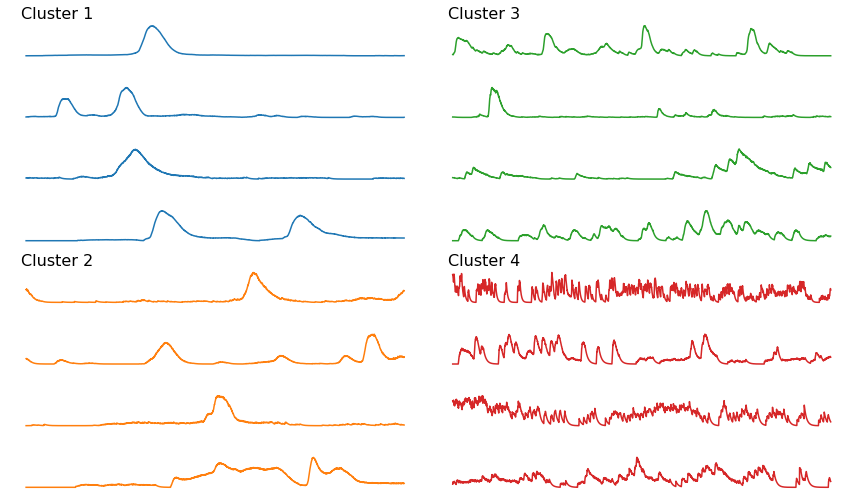

In [57]:
fig = plt.figure(figsize=(12, 7))
nrows, ncols = 4*2, 2
axs = fig.subplots(nrows, ncols) # 3 examples from each cluster

colors = map_labels_to_colors(cluster_numbers, 'tab10')

i = 0
for ax_i in range(ncols):
    for ax_j in range(nrows):
        axs[ax_j, ax_i].plot(curves[i], c=colors[i])
        axs[ax_j, ax_i].axis('off')
        
        if i % 4 == 0:
            axs[ax_j, ax_i].set_title(f"Cluster {cluster_numbers[i]}", y = 1, x=0.12, fontdict={'fontsize': 16})
        
        i += 1
plt.tight_layout()
fig.savefig('/home/kushal/Sars_stuff/Dropbox/fig_data/hier_ciona_neuronal_detailed/examples_from_hier_all.png', dpi=600, bbox_inches='tight', pad_inches=0)

# DB Score of EMD FFT

In [ ]:
cluster_range = range(2, 13)
scores = OrderedDict.fromkeys(cluster_range)

for nc in tqdm(cluster_range):
    Z = linkage(dm_emd_fdata, method='complete', optimal_ordering=True)
    labels = fcluster(Z, t=nc, criterion='maxclust')
    
    score = davies_bouldin_score_emd(fdata, labels, metric=emd_1d)
    
    scores[nc] = score

scores_d = {k: v[0] for k, v in scores.items()}

In [25]:
# json.dump(scores_d, open('/home/kushal/Sars_stuff/Dropbox/fig_drafts/nat_com_2020/db_scores/emd.json', 'w'), indent=4)

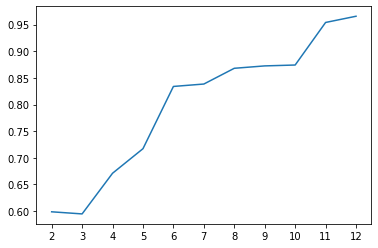

OrderedDict([('2', 0.5986816356204243),
             ('3', 0.5947111953302572),
             ('4', 0.6710204931473223),
             ('5', 0.7171072713319914),
             ('6', 0.833912474931079),
             ('7', 0.8384416021997388),
             ('8', 0.8679827410643393),
             ('9', 0.8724650544953048),
             ('10', 0.8741152762342743),
             ('11', 0.9539814797049506),
             ('12', 0.9656458176336359)])

In [26]:
def get_db_emd_fdata(plot=True):
    cluster_range = range(2, 13)
    scores_db_emd_fdata = OrderedDict(json.load(open('/home/kushal/Sars_stuff/Dropbox/fig_drafts/nat_com_2020/db_scores/emd.json')))
    if plot:
        plt.plot(list(scores_db_emd_fdata.values()))
        plt.xticks(range(len(cluster_range)), list(cluster_range))
        plt.show()
    return scores_db_emd_fdata

get_db_emd_fdata(plot=True)

# DB Score Euc of FFT

100%|██████████| 11/11 [00:00<00:00, 48.15it/s]


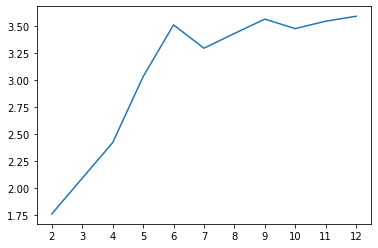

OrderedDict([(2, 1.7600361576028212),
             (3, 2.0904454056899358),
             (4, 2.419836642728333),
             (5, 3.030724225868158),
             (6, 3.510028231918703),
             (7, 3.294111320512393),
             (8, 3.4307410173287374),
             (9, 3.563523207900836),
             (10, 3.4754565669554296),
             (11, 3.544232819563004),
             (12, 3.5900177834770486)])

In [22]:
def get_db_euc_fdata(plot=True):
    cluster_range = range(2, 13)
    scores_db_euc_fdata = OrderedDict.fromkeys(cluster_range)

    for nc in tqdm(cluster_range):
        Z = linkage(dm_euc_fdata, method='complete', optimal_ordering=True)
        labels = fcluster(Z, t=nc, criterion='maxclust')

        score = davies_bouldin_score(fdata, labels)

        scores_db_euc_fdata[nc] = score

    json.dump(
        scores_db_euc_fdata, 
        open('/home/kushal/Sars_stuff/Dropbox/fig_drafts/nat_com_2020/db_scores/euc.json', 'w'), 
        indent=4
    )
    
    if plot:
        plt.plot(list(scores_db_euc_fdata.values()))
        plt.xticks(range(len(cluster_range)), list(cluster_range))
        plt.show()
    
    return scores_db_euc_fdata
    
get_db_euc_fdata(plot=True)

# Silh Score EMD of FFT

100%|██████████| 11/11 [00:00<00:00, 39.12it/s]


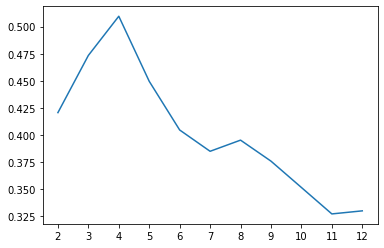

OrderedDict([(2, 0.4205030109032022),
             (3, 0.4733786001810921),
             (4, 0.5096243061574968),
             (5, 0.4494688300939015),
             (6, 0.4044604781417066),
             (7, 0.38476027931478035),
             (8, 0.3950703979682432),
             (9, 0.37565270394773254),
             (10, 0.3512895676763104),
             (11, 0.32685052413740057),
             (12, 0.3296833838833458)])

In [23]:
def get_sh_emd_fdata(plot=True):
    cluster_range = range(2, 13)

    scores_sh_emd_fdata = OrderedDict.fromkeys(cluster_range)

    for nc in tqdm(cluster_range):
        Z = linkage(dm_emd_fdata, method='complete', optimal_ordering=True)
        labels = fcluster(Z, t=nc, criterion='maxclust')

        score = silhouette_score(squareform(dm_emd_fdata), labels, metric='precomputed', n_jobs=22)

        scores_sh_emd_fdata[nc] = score
    
    if plot:
        plt.plot(list(scores_sh_emd_fdata.values()))
        plt.xticks(range(len(cluster_range)), list(cluster_range))
        plt.show()
        
    return scores_sh_emd_fdata

get_sh_emd_fdata(True)

# Silh Score EMD of FFT (Neuronal only)

100%|██████████| 11/11 [00:00<00:00, 151.59it/s]


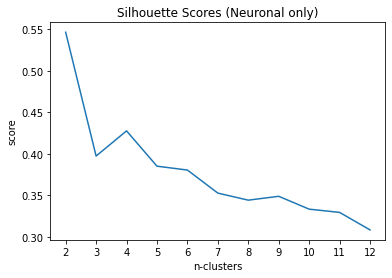

OrderedDict([(2, 0.5462873604327649),
             (3, 0.39720755883017633),
             (4, 0.4275166911574513),
             (5, 0.3850109433100298),
             (6, 0.38033246297057627),
             (7, 0.3525764311873895),
             (8, 0.34408661626370113),
             (9, 0.3487367354782896),
             (10, 0.3332446432223032),
             (11, 0.3293501505259984),
             (12, 0.3082515874319105)])

In [33]:
def get_sh_emd_fdata_neuronal(plot=True):
    cluster_range = range(2, 13)

    scores_sh_emd_fdata_neuronal = OrderedDict.fromkeys(cluster_range)

    for nc in tqdm(cluster_range):
        Z = linkage(squareform(neuronal_dm_emd_fdata_sf), method='complete', optimal_ordering=True)
        labels = fcluster(Z, t=nc, criterion='maxclust')

        score = silhouette_score(neuronal_dm_emd_fdata_sf, labels, metric='precomputed', n_jobs=22)

        scores_sh_emd_fdata_neuronal[nc] = score
    
    if plot:
        plt.plot(list(scores_sh_emd_fdata_neuronal.values()))
        plt.xticks(range(len(cluster_range)), list(cluster_range))
        plt.title("Silhouette Scores (Neuronal only)")
        plt.xlabel("n-clusters")
        plt.ylabel("score")
        plt.savefig('/home/kushal/Sars_stuff/Dropbox/nat_comm_resubmission/suppl/silh_scores_neuronal.png', dpi=600)
        plt.show()
        
    return scores_sh_emd_fdata_neuronal

get_sh_emd_fdata_neuronal(True)

In [25]:
df_neuronal.index.size

143

In [26]:
len(list(colors_cell_type))

0

In [33]:
cell_name_abr = json.load(open('./abbreviations.json', 'r'))
df_neuronal.cell_name = df_neuronal.cell_name.apply(cell_name_abr.get)

# Detailed EMD clustering of Neuronal data, used for fig 5. n_cluster is 2nd highest Silh score value

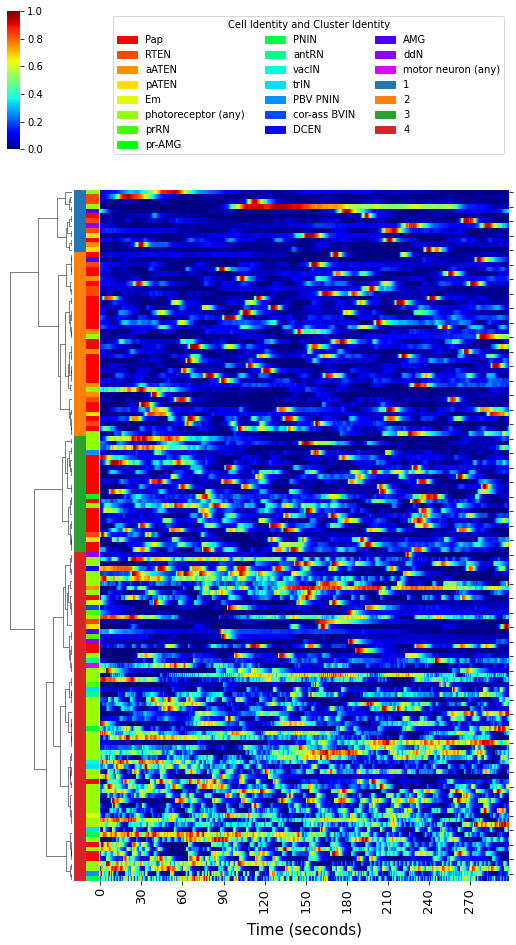

In [43]:
Z = linkage(squareform(neuronal_dm_emd_fdata_sf), method='complete', optimal_ordering=True)
labels = fcluster(Z, t=4, criterion='maxclust')

df_neuronal['FCLUSTER_LABELS_NEURONAL'] = labels

sort_ixs = np.argsort(labels)

cmap_cluster = get_colormap(labels, 'tab10')
colors_cluster = map(cmap_cluster.get, labels)

cmap_cell_type = get_colormap([c for c in cell_name_abr.values() if c in df_neuronal.cell_name.unique()], 'hsv')
colors_cell_type = map(cmap_cell_type.get, df_neuronal.cell_name.values)

tdata_neuronal = np.vstack(df_neuronal._NORMALIZE.values)

cfig = sns.clustermap(tdata_neuronal, row_colors=[colors_cluster, colors_cell_type], row_linkage=Z, col_cluster=False, cmap='jet', figsize=(9, 16))

# legend
cfig.ax_col_dendrogram.cla()
handles = \
    [MPatch(color=cmap_cell_type[k], label=k) for k in cmap_cell_type.keys()] + \
    [MPatch(color=cmap_cluster[k], label=k) for k in cmap_cluster.keys()]

cfig.ax_col_dendrogram.legend(handles=handles, ncol=3, title='Cell Identity and Cluster Identity')
cfig.ax_col_dendrogram.get_xaxis().set_visible(False)
cfig.ax_col_dendrogram.get_yaxis().set_visible(False)

cfig.ax_heatmap.set_xticks(np.arange(0, frames_length, xticks_interval * sampling_rate))
cfig.ax_heatmap.set_xticklabels(np.arange(0, recording_time, xticks_interval), fontdict={'fontsize': 13})

cfig.ax_heatmap.tick_params(labelright=False)

cfig.ax_heatmap.set_xlabel('Time (seconds)', fontdict={'fontsize': 15}, labelpad=10)

cfig.cax.set_visible(True)

cfig.savefig('/home/kushal/Sars_stuff/Dropbox/fig_data/hier_ciona_neuronal_detailed/hier_neuronal.png', dpi=600, pad_inches=0, bbox_inches='tight')

In [51]:
props_df = get_proportions(
    xs=df_neuronal.cell_name,
    ys=df_neuronal.FCLUSTER_LABELS_NEURONAL, 
    xs_name='Cell Identity', 
    ys_name='Cluster'
)

In [52]:
props_df.fillna(value=0, inplace=True)

In [53]:
to_drop = map(cell_name_abr.get, ['cor_ass_bvin', 'dcen', 'vac_in'])
props_df.drop(to_drop, axis='index', inplace=True)

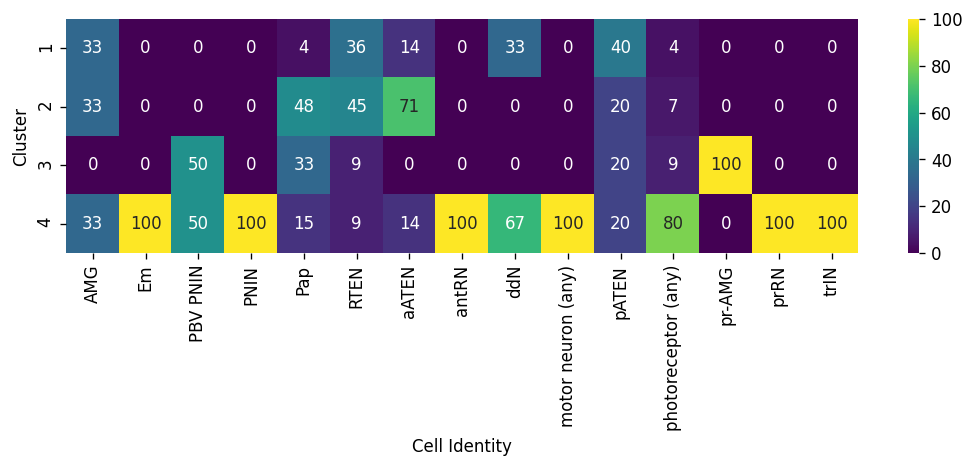

In [54]:
fig = plt.figure(figsize=(9,4), dpi=120)
sns.heatmap(props_df.T, cmap='viridis', annot=True, fmt="0.0f")
plt.tight_layout()

In [55]:
Z = linkage(props_df, optimal_ordering=True, method='complete', metric='euclidean')

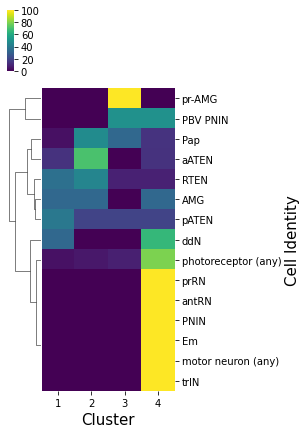

In [56]:
cm = sns.clustermap(data=props_df, row_linkage=Z, col_cluster=False, cmap='viridis', figsize=(3, 7))
cm.ax_heatmap.set_ylabel("Cell Identity", fontdict={'fontsize': 15})
cm.ax_heatmap.set_xlabel("Cluster", fontdict={'fontsize': 15})


cm.savefig('/home/kushal/Sars_stuff/Dropbox/fig_data/hier_ciona_neuronal_detailed/hier_neuronal_props.png', dpi=600, pad_inches=0, bbox_inches='tight')

# Getting the centerlikes (centroid) from each of the 4 clusters

In [28]:
# Centerlike function from mesmerize
def get_centerlike(cluster_members: np.ndarray, 
                   metric: Optional[Union[str, callable]] = None,
                   dist_matrix: Optional[np.ndarray] = None, 
                   n_jobs: int = 16
                  ) -> Tuple[np.ndarray, int]:
    """
    Finds the 1D time-series within a cluster that is the most centerlike

    :param cluster_members: 2D numpy array in the form [n_samples, 1D time_series]
    :param metric:          Metric to use for pairwise distance calculation, simply passed to sklearn.metrics.pairwise_distances
    :param dist_matrix:     Distance matrix of the cluster members

    :return:                The cluster member which is most centerlike, and its index in the cluster_members array
    """
    if dist_matrix is None:
        dist_matrix = pairwise_distances(cluster_members, metric=metric, n_jobs=n_jobs)

    c_ix = np.argmin(np.sum(dist_matrix, axis=0))
    c = cluster_members[c_ix, :]
    return c, c_ix

Or recompute the centerlikes by setting the following cell to "code" instead of "raw"

In [29]:
# sanity check
df_neuronal.index.to_list() == list(range(df_neuronal.index.size))

True

100%|██████████| 4/4 [00:00<00:00, 310.74it/s]


Text(0.5, 0.935, 'Cluster Centroids')

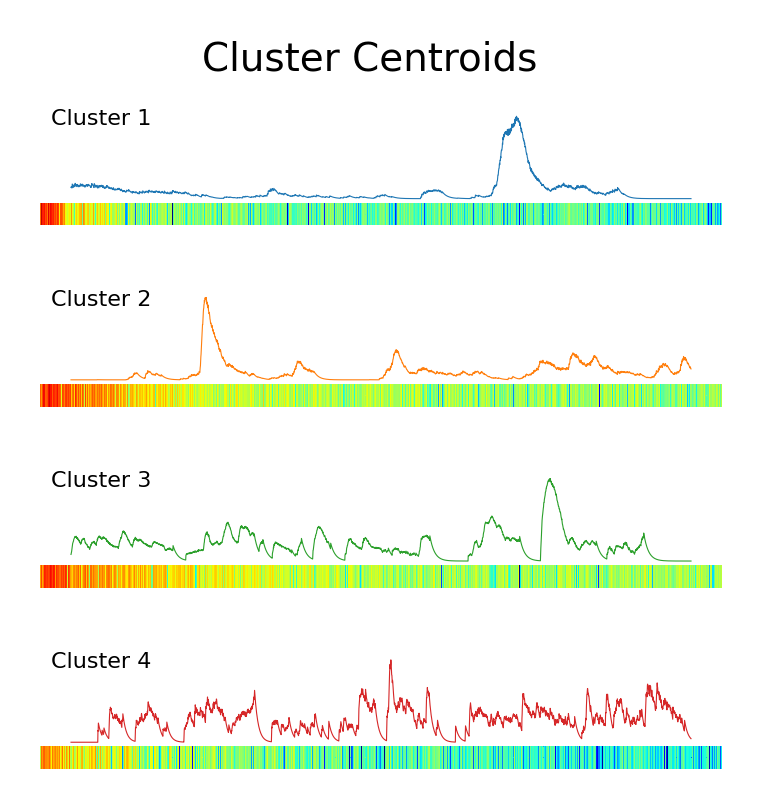

In [30]:
cluster_labels = df_neuronal.FCLUSTER_LABELS_NEURONAL.unique()
cluster_labels.sort()

center_likes = dict.fromkeys(cluster_labels)
center_like_dfts = dict.fromkeys(cluster_labels)

# Get the frequency domain data
rdata = np.vstack(df_neuronal._SPLICE_ARRAYS.values)
# EMD cannot be calculated using negative weights
rdata += np.abs(rdata.min())
df_neuronal['_ADD_MIN'] = rdata.tolist()
df_neuronal['_ADD_MIN'] = df_neuronal['_ADD_MIN'].apply(np.array)

# Get center-likes for each cluster
for label in tqdm(cluster_labels):
    del_ixs = df_neuronal[df_neuronal.FCLUSTER_LABELS_NEURONAL != label].index.to_list()
    
    memb_dm = np.delete(neuronal_dm_emd_fdata_sf, del_ixs, axis=0)
    
    memb_dm = np.delete(memb_dm, del_ixs, axis=1)
    
    # sanity check
#     sns.heatmap(neuronal_dm_emd_fdata_sf)
#     plt.show()
#     sns.heatmap(memb_dm)
#     plt.show()
#     sns.heatmap(memb_dm)
#     plt.show()
    
    # Cluster members, freq domain data
    membs = np.vstack(df_neuronal._ADD_MIN[df_neuronal.FCLUSTER_LABELS_NEURONAL == label].values)
    
    # Cluster members, time domain data
    curves = np.vstack(df_neuronal._NORMALIZE[df_neuronal.FCLUSTER_LABELS_NEURONAL == label].values)
    
    # Get the index of the centerlike within the cluster
    ix = get_centerlike(membs, metric=emd_1d, dist_matrix=memb_dm, n_jobs=22)[1] # Adjust n_jobs if you have more threads available
    
    # Get the centerlikes in the time and frequency domains
    center_likes[label] = curves[ix]
    center_like_dfts[label] = membs[ix]
    
# Draw the centerlikes with the time-domain plotted as trace over a band illustrating the frequency domain of the same data.
nrows = (4 * 10) + 4
ncols = 1

fig = plt.figure(figsize=(2.2, 3.3), dpi=400)
gs = gridspec.GridSpec(nrows, ncols)
gs.update(wspace=0.15, hspace=0.0)
axs = []

plot_ixs = range(8)

cmap = auto_colormap(n_colors=10, cmap='tab10')

cluster_label = 0
for i in plot_ixs:
    if i % 2 == 0:
        ax = fig.add_subplot(gs[4*i:4*i+4])
        ax.plot(center_likes[cluster_label + 1], c=cmap[cluster_label], linewidth=0.2)
        ax.axis('off')
        ax.set_title(f'Cluster {cluster_label + 1}', fontdict={'fontsize': 4}, y=0.50, x=0.09)
        cluster_label += 1
    else:
        ax = fig.add_subplot(gs[4*i:4*i+1])
        a = center_like_dfts[cluster_label]
        hm = sns.heatmap(np.array([a, a]), cmap='jet', ax=ax, cbar=False, vmin=a.min(), vmax=a.max())
        ax.axis('off')

fig.suptitle("Cluster Centroids", fontsize=7, y=0.935)
        
#fig.savefig('/home/kushal/Sars_stuff/Dropbox/fig_data/hier_ciona_neuronal_detailed/centroids.png', dpi=600, bbox_inches='tight', pad_inches=0)

# Example traces from each cluster

In [83]:
choices = OrderedDict.fromkeys(cluster_labels)

curves = []
cluster_numbers = []
for label in tqdm(cluster_labels):
    # Cluster members, time domain data
    membs = np.vstack(df_neuronal._NORMALIZE[df_neuronal.FCLUSTER_LABELS_NEURONAL == label].values)
    
    curves.append(np.vstack(membs[np.random.choice(membs.shape[0], 4, replace=False)]))
    cluster_numbers.append([label]*4)

curves = np.concatenate(curves)
cluster_numbers = np.array(cluster_numbers).flatten()

100%|██████████| 4/4 [00:00<00:00, 1384.72it/s]


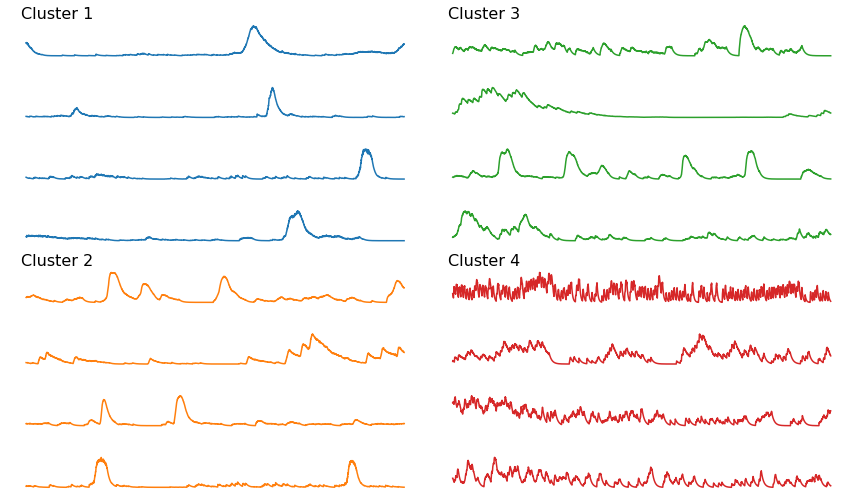

In [85]:
fig = plt.figure(figsize=(12, 7))
nrows, ncols = 4*2, 2
axs = fig.subplots(nrows, ncols) # 3 examples from each cluster

colors = map_labels_to_colors(cluster_numbers, 'tab10')

i = 0
for ax_i in range(ncols):
    for ax_j in range(nrows):
        axs[ax_j, ax_i].plot(curves[i], c=colors[i])
        axs[ax_j, ax_i].axis('off')
        
        if i % 4 == 0:
            axs[ax_j, ax_i].set_title(f"Cluster {cluster_numbers[i]}", y = 1, x=0.12, fontdict={'fontsize': 16})
        
        i += 1
plt.tight_layout()
# fig.savefig('/home/kushal/Sars_stuff/Dropbox/fig_data/hier_ciona_neuronal_detailed/examples.png', dpi=600, bbox_inches='tight', pad_inches=0)

# Silh Score Euc of FFT

100%|██████████| 11/11 [00:00<00:00, 50.27it/s]


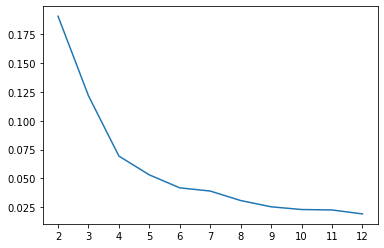

OrderedDict([(2, 0.19032313651686253),
             (3, 0.12152093205621413),
             (4, 0.06935886643483495),
             (5, 0.0531087596514566),
             (6, 0.04187545964638322),
             (7, 0.039112354684572095),
             (8, 0.03090718288924532),
             (9, 0.025496367170023047),
             (10, 0.023128502233114426),
             (11, 0.02275606640714991),
             (12, 0.01933322104610419)])

In [40]:
def get_sh_euc_fdata(plot=True):
    cluster_range = range(2, 13)
    scores_sh_euc_fdata = OrderedDict.fromkeys(cluster_range)

    for nc in tqdm(cluster_range):
        Z = linkage(dm_euc_fdata, method='complete', optimal_ordering=True)
        labels = fcluster(Z, t=nc, criterion='maxclust')

        score = silhouette_score(squareform(dm_euc_fdata), labels, metric='precomputed', n_jobs=22)

        scores_sh_euc_fdata[nc] = score

#     json.dump(scores_sh_euc_fdata, open('/home/kushal/Sars_stuff/Dropbox/fig_drafts/nat_com_2020/db_scores/euc_silh.json', 'w'), indent=4)
    
    if plot:
        plt.plot(list(scores_sh_euc_fdata.values()))
        plt.xticks(range(len(cluster_range)), list(cluster_range))
        plt.show()
    return scores_sh_euc_fdata

get_sh_euc_fdata(True)

# KMeans FFT

100%|██████████| 11/11 [00:00<00:00, 16.18it/s]


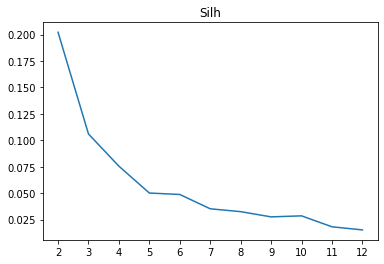

OrderedDict([(2, 0.20217168963779739),
             (3, 0.10593505596370086),
             (4, 0.07549505060969507),
             (5, 0.05008833626177781),
             (6, 0.04872921816599014),
             (7, 0.035179623717764424),
             (8, 0.03248659580555271),
             (9, 0.027532970915991366),
             (10, 0.028513842833834572),
             (11, 0.01815395749524415),
             (12, 0.01520526460948604)])

In [41]:
def get_sh_km_fdata(plot=True):
    cluster_range = range(2, 13)

    scores_sh_km_fdata = OrderedDict.fromkeys(cluster_range)


    for nc in tqdm(cluster_range):
        km = KMeans(n_clusters=nc)
        labels = km.fit_predict(fdata)
        score = silhouette_score(squareform(dm_euc_fdata), labels, metric='precomputed', n_jobs=22)

        scores_sh_km_fdata[nc] = score
    
    if plot:
        plt.plot(list(scores_sh_km_fdata.values()))
        plt.xticks(range(len(cluster_range)), list(cluster_range))
        plt.title("Silh")
        plt.show()
        
    return scores_sh_km_fdata

get_sh_km_fdata(True)

100%|██████████| 11/11 [00:00<00:00, 15.93it/s]


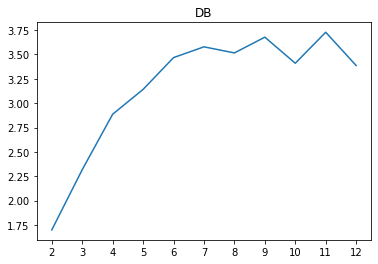

OrderedDict([(2, 1.698035430276364),
             (3, 2.3169218653951007),
             (4, 2.8865902947603606),
             (5, 3.1416598934724456),
             (6, 3.468053279123168),
             (7, 3.578647673454813),
             (8, 3.5161003992872994),
             (9, 3.6778358372427937),
             (10, 3.410183869077624),
             (11, 3.728543169124521),
             (12, 3.386542596430756)])

In [42]:
def get_db_km_fdata(plot=True):
    cluster_range = range(2, 13)
    scores_db_km_fdata = OrderedDict.fromkeys(cluster_range)

    for nc in tqdm(cluster_range):
        km = KMeans(n_clusters=nc)
        labels = km.fit_predict(fdata)
        score = davies_bouldin_score(fdata, labels)

        scores_db_km_fdata[nc] = score
    
    if plot:
        plt.plot(list(scores_db_km_fdata.values()))
        plt.xticks(range(len(cluster_range)), list(cluster_range))
        plt.title("DB")
        plt.show()
    
    return scores_db_km_fdata
    
get_db_km_fdata()

<Figure size 720x936 with 0 Axes>

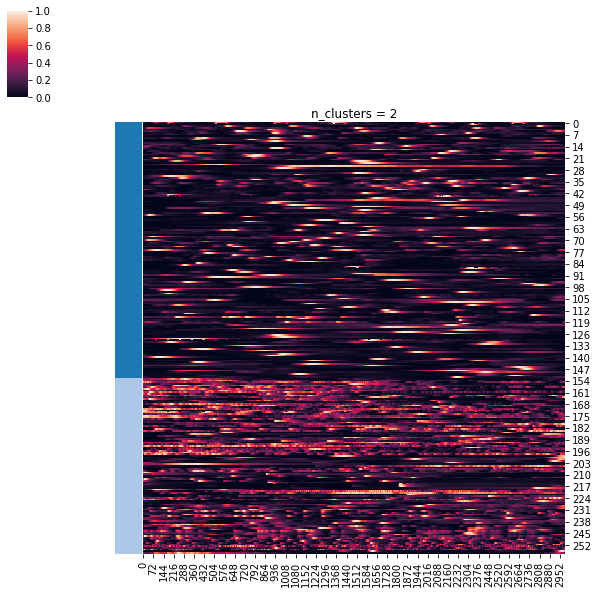

<Figure size 720x936 with 0 Axes>

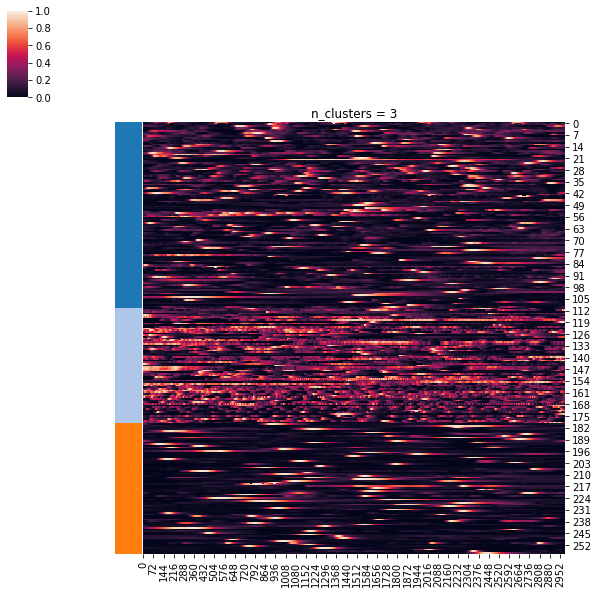

<Figure size 720x936 with 0 Axes>

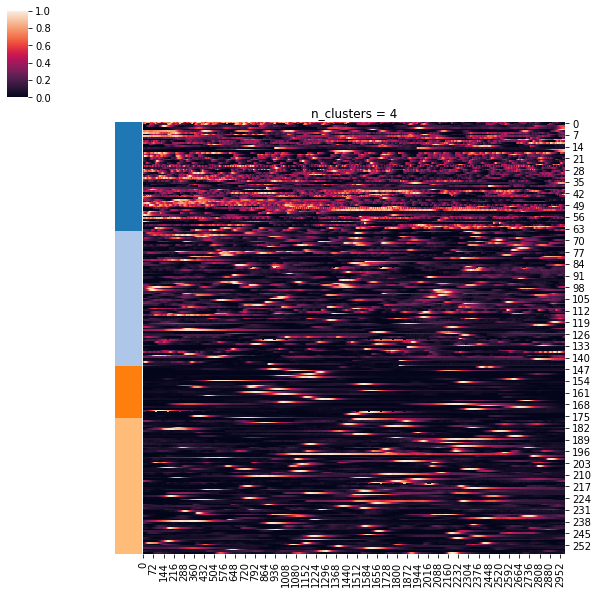

<Figure size 720x936 with 0 Axes>

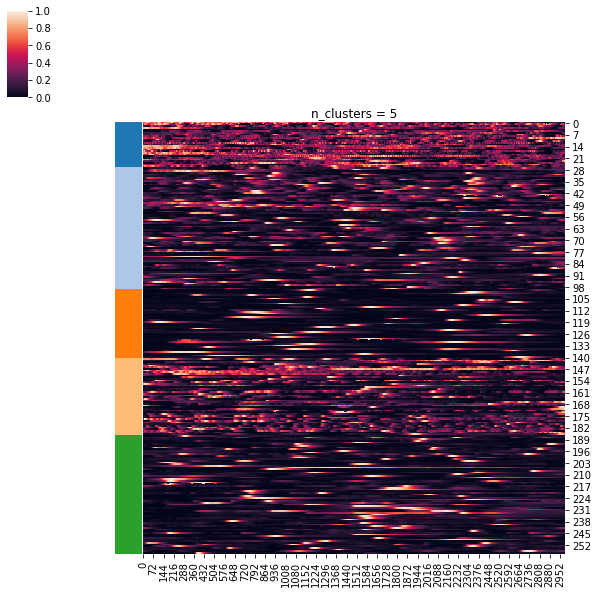

<Figure size 720x936 with 0 Axes>

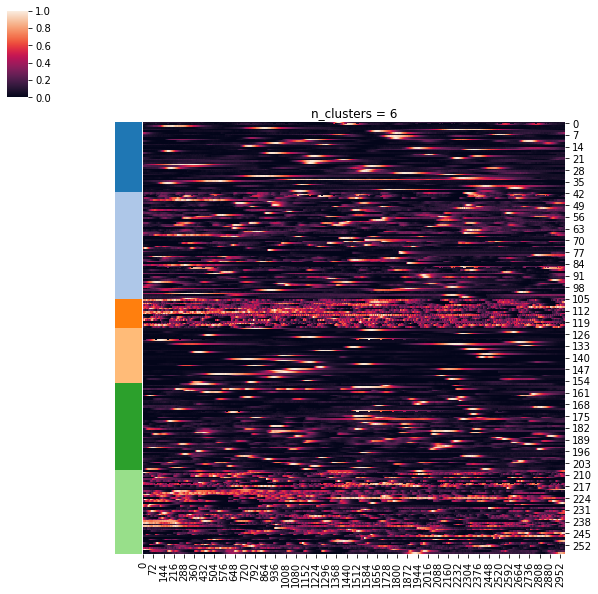

<Figure size 720x936 with 0 Axes>

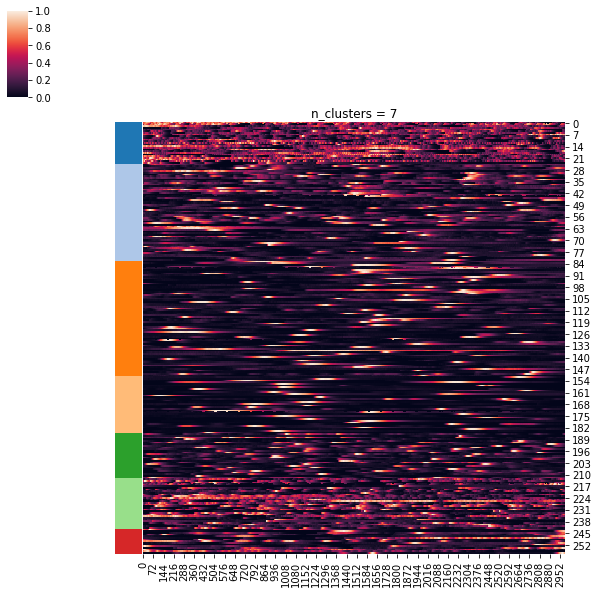

<Figure size 720x936 with 0 Axes>

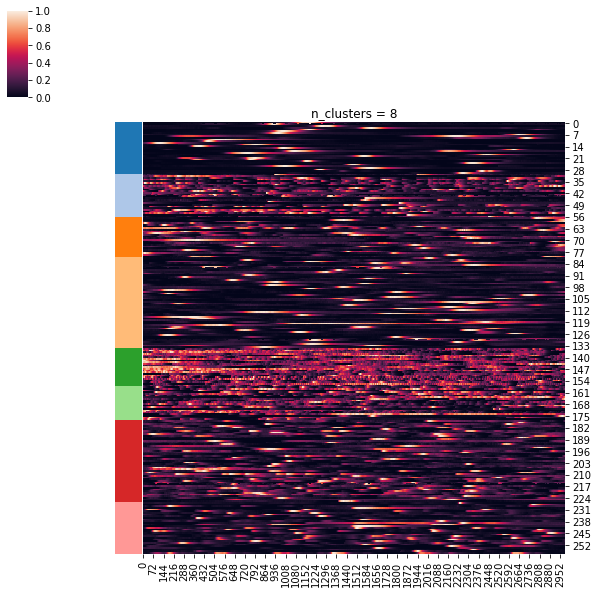

<Figure size 720x936 with 0 Axes>

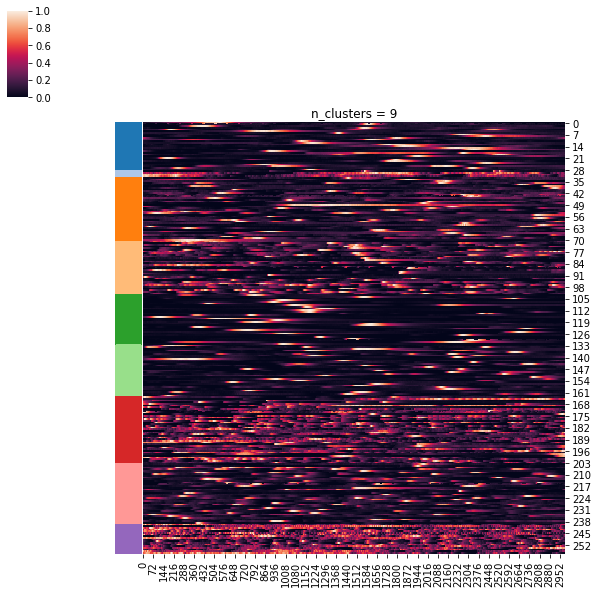

<Figure size 720x936 with 0 Axes>

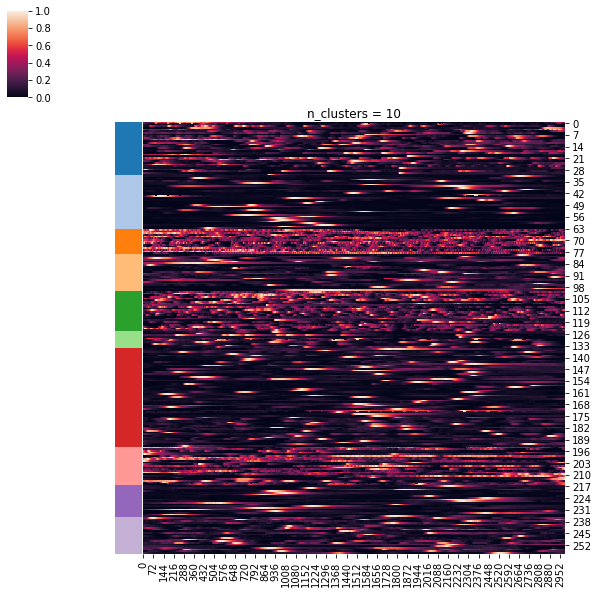

<Figure size 720x936 with 0 Axes>

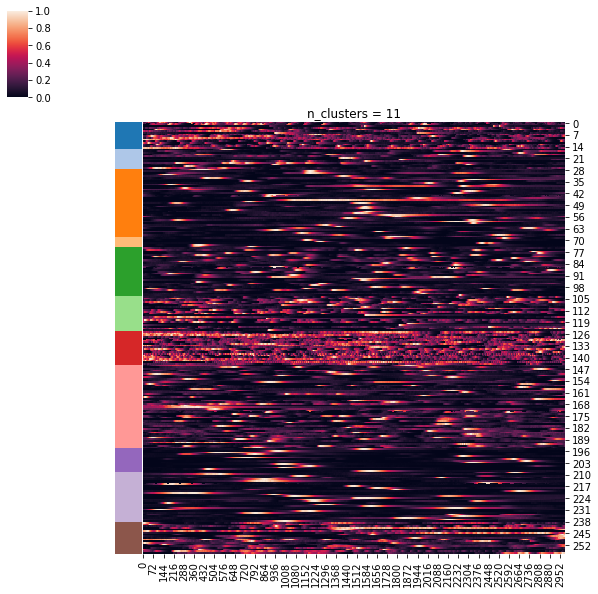

<Figure size 720x936 with 0 Axes>

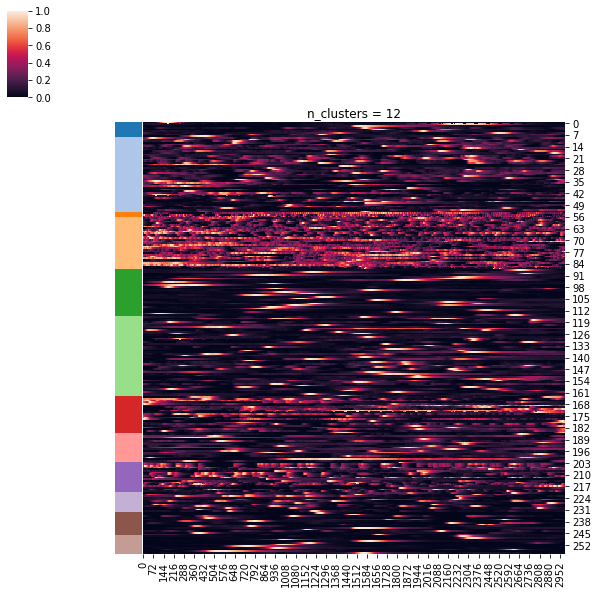

In [43]:
cluster_range = range(2, 13)
scores = OrderedDict.fromkeys(cluster_range)

for nc in cluster_range:
    fig = plt.figure(figsize=(10, 13))
    km = KMeans(n_clusters=nc)
    labels = km.fit_predict(fdata)
    sort_ixs = np.argsort(labels)
    row_colors = map_labels_to_colors(labels[sort_ixs], 'tab20')
    f = sns.clustermap(tdata[sort_ixs], row_colors=row_colors, row_cluster=False, col_cluster=False)
    f.ax_heatmap.set_title(f"n_clusters = {nc}")
    plt.show()

# KMeans Time

100%|██████████| 11/11 [00:01<00:00,  5.68it/s]


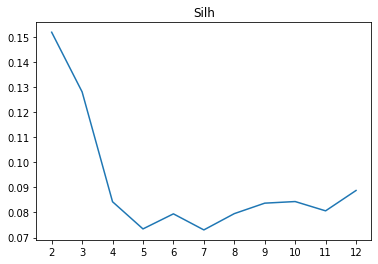

OrderedDict([(2, 0.15191778337509598),
             (3, 0.1281216980127905),
             (4, 0.08427815957405771),
             (5, 0.07343185583292826),
             (6, 0.07944478820151588),
             (7, 0.07303226298842895),
             (8, 0.07953023912685216),
             (9, 0.08370930390278195),
             (10, 0.08435369409784035),
             (11, 0.08064240812627892),
             (12, 0.08876936339467811)])

In [44]:
def get_sh_km_tdata(plot=True):
    cluster_range = range(2, 13)
    scores_sh_km_tdata = OrderedDict.fromkeys(cluster_range)


    for nc in tqdm(cluster_range):
        km = KMeans(n_clusters=nc)
        labels = km.fit_predict(tdata)
        score = silhouette_score(squareform(dm_euc_tdata), labels, metric='precomputed', n_jobs=22)

        scores_sh_km_tdata[nc] = score
    
    if plot:
        plt.plot(list(scores_sh_km_tdata.values()))
        plt.xticks(range(len(cluster_range)), list(cluster_range))
        plt.title("Silh")
        plt.show()
        
    return scores_sh_km_tdata

get_sh_km_tdata(True)

100%|██████████| 11/11 [00:01<00:00,  5.58it/s]


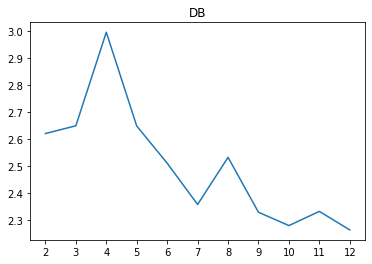

OrderedDict([(2, 2.6216407834207947),
             (3, 2.650302090606897),
             (4, 2.9965926752141994),
             (5, 2.649441719970031),
             (6, 2.511985420586377),
             (7, 2.358896250648803),
             (8, 2.533551935301449),
             (9, 2.3302503329121373),
             (10, 2.2809280334734185),
             (11, 2.333384320027626),
             (12, 2.264846639035753)])

In [45]:
def get_db_km_tdata(plot=True):
    cluster_range = range(2, 13)
    scores_db_km_tdata = OrderedDict.fromkeys(cluster_range)

    for nc in tqdm(cluster_range):
        km = KMeans(n_clusters=nc)
        labels = km.fit_predict(tdata)
        score = davies_bouldin_score(tdata, labels)

        scores_db_km_tdata[nc] = score
        
    if plot:
        plt.plot(list(scores_db_km_tdata.values()))
        plt.xticks(range(len(cluster_range)), list(cluster_range))
        plt.title("DB")
        plt.show()
    
    return scores_db_km_tdata

get_db_km_tdata(True)

<Figure size 720x936 with 0 Axes>

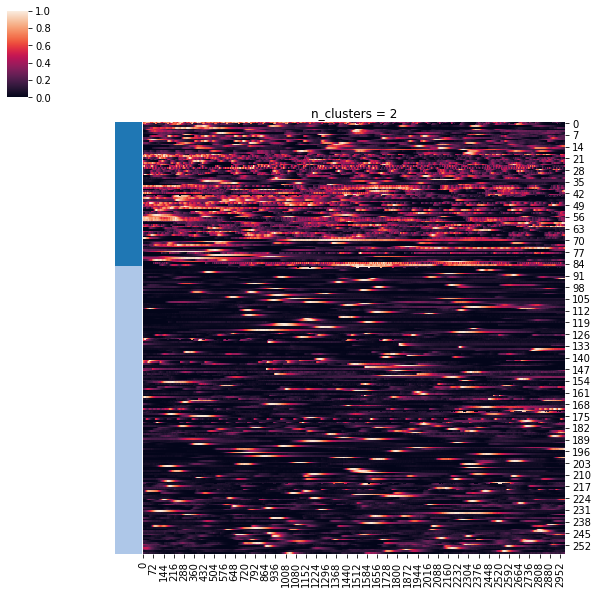

<Figure size 720x936 with 0 Axes>

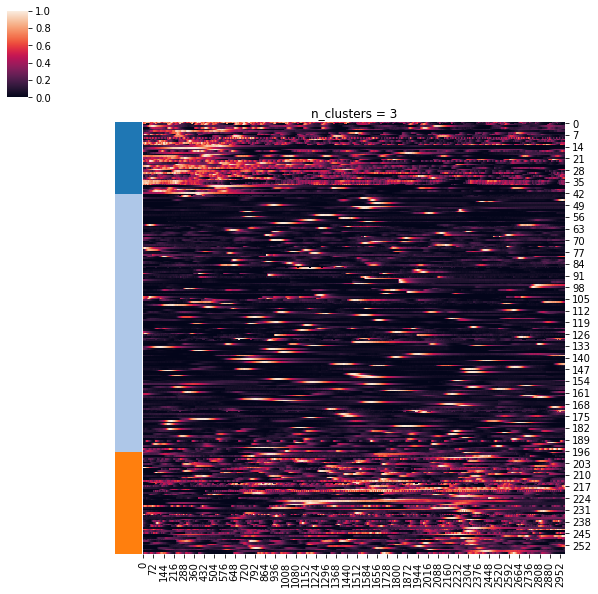

<Figure size 720x936 with 0 Axes>

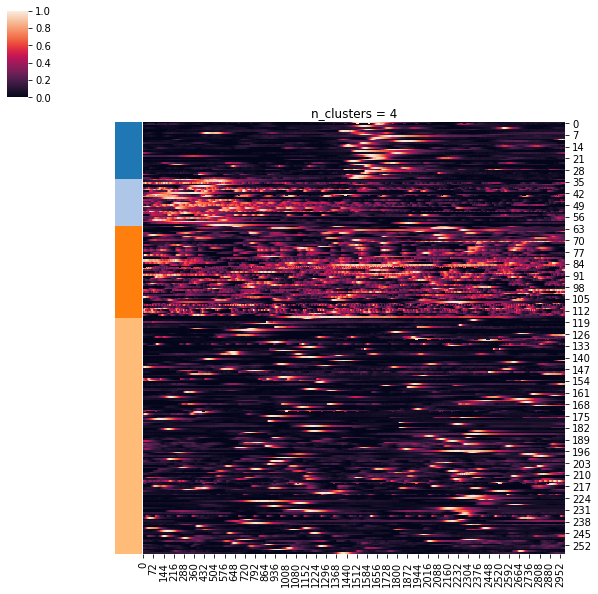

<Figure size 720x936 with 0 Axes>

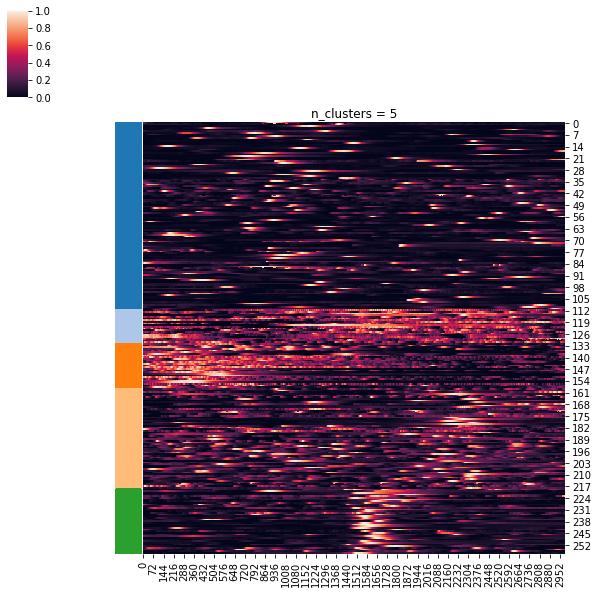

<Figure size 720x936 with 0 Axes>

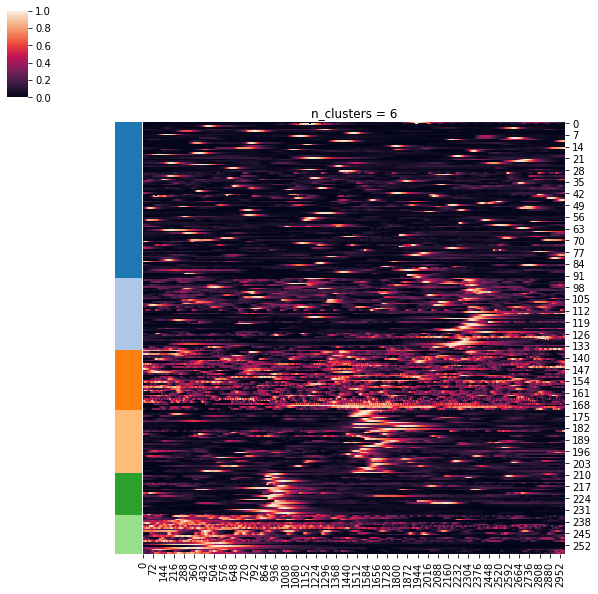

<Figure size 720x936 with 0 Axes>

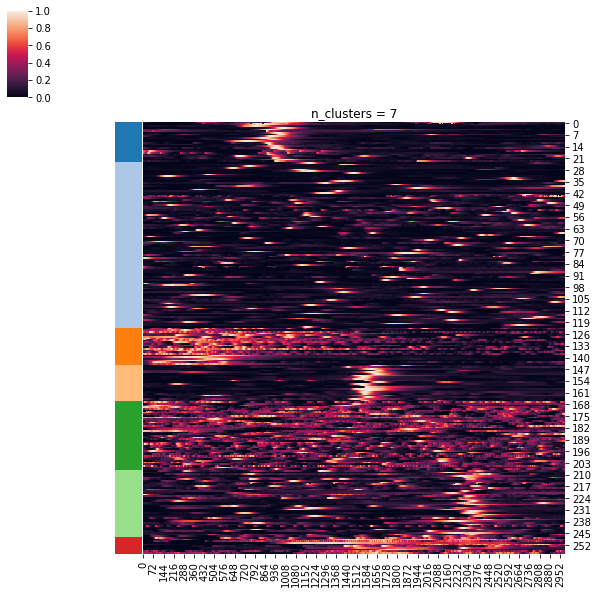

<Figure size 720x936 with 0 Axes>

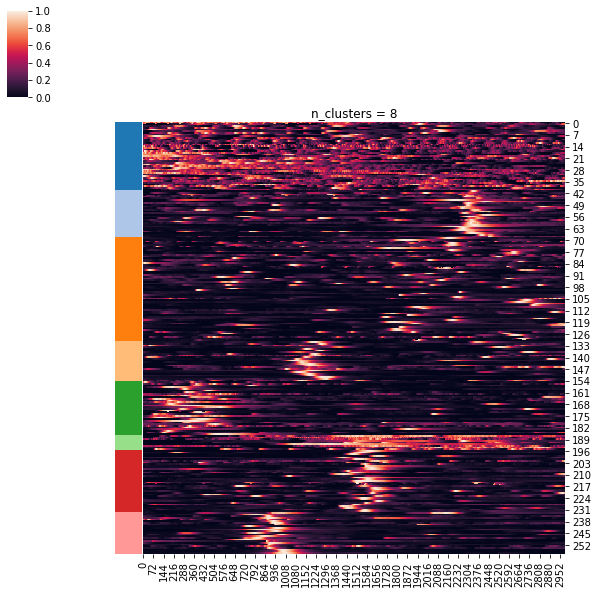

<Figure size 720x936 with 0 Axes>

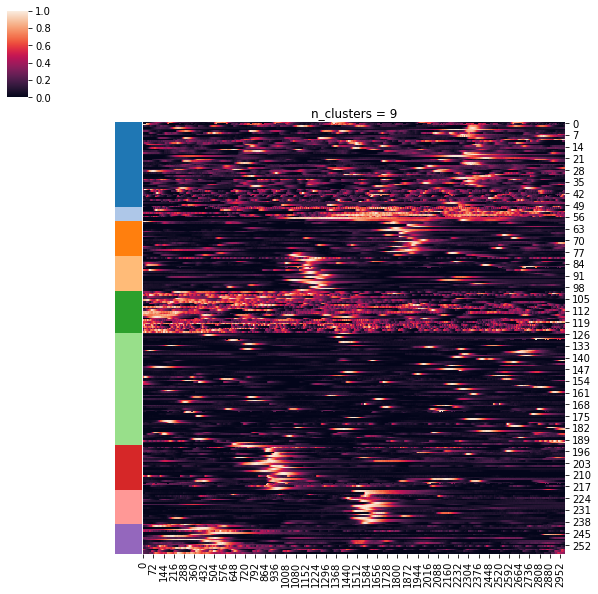

<Figure size 720x936 with 0 Axes>

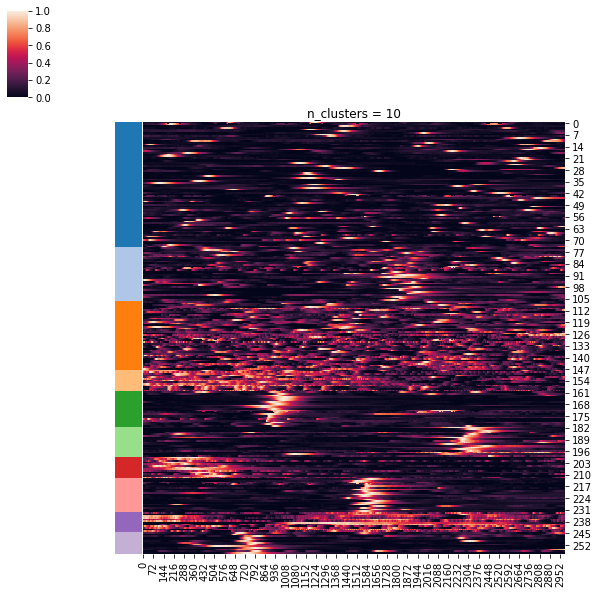

<Figure size 720x936 with 0 Axes>

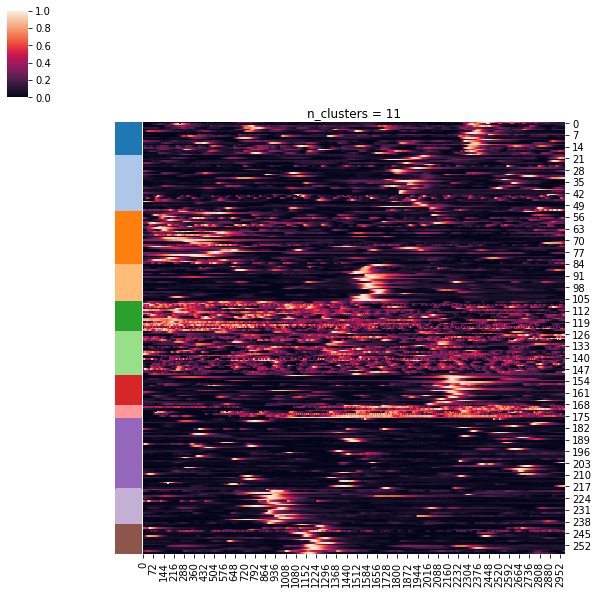

<Figure size 720x936 with 0 Axes>

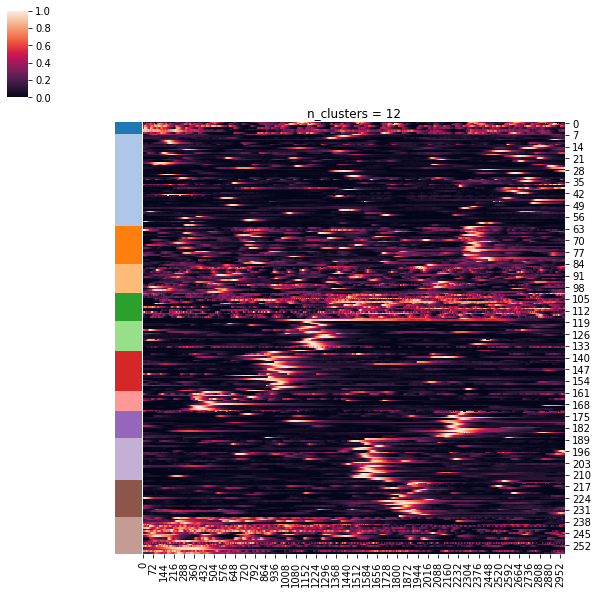

In [44]:
cluster_range = range(2, 13)
scores = OrderedDict.fromkeys(cluster_range)

for nc in cluster_range:
    fig = plt.figure(figsize=(10, 13))
    km = KMeans(n_clusters=nc)
    labels = km.fit_predict(tdata)
    sort_ixs = np.argsort(labels)
    row_colors = map_labels_to_colors(labels[sort_ixs], 'tab20')
    f = sns.clustermap(tdata[sort_ixs], row_colors=row_colors, row_cluster=False, col_cluster=False)
    f.ax_heatmap.set_title(f"n_clusters = {nc}")
    plt.savefig(f'/home/kushal/Sars_stuff/Dropbox/nat_comm_resubmission/suppl/kmeans_cell_types/{nc}-clusters', dpi=600)
    plt.show()
    

# Summarize Silh Scores

100%|██████████| 11/11 [00:01<00:00,  5.78it/s]


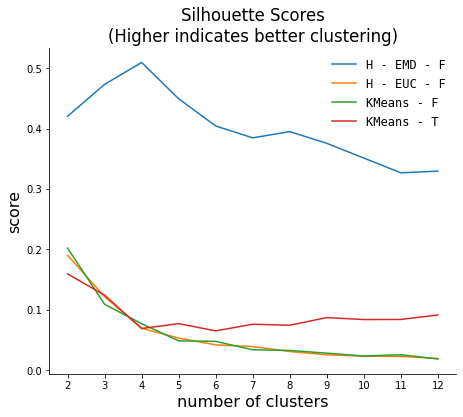

In [47]:
cluster_range = range(2, 13)

silh_scores = \
{
    'H - EMD - F': list(get_sh_emd_fdata(plot=False).values()),
    'H - EUC - F': list(get_sh_euc_fdata(plot=False).values()),
    'KMeans - F':       list(get_sh_km_fdata(plot=False).values()),
    'KMeans - T':       list(get_sh_km_tdata(plot=False).values())
}

fig = plt.figure(figsize=(7.3, 6))
ax = plt.subplot(111)

for method, scores in silh_scores.items():
    plt.plot(scores, label=method)

plt.title("Silhouette Scores\n(Higher indicates better clustering)", fontdict={'size': 16.5})

leg = ax.legend(prop={'family': 'monospace', 'size': 12},frameon=False)
plt.xticks(range(len(cluster_range)), list(cluster_range))
plt.ylabel("score", fontdict={'size': 16})
plt.xlabel("number of clusters", fontdict={'size': 16})

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# fig.savefig(
#     '/home/kushal/Sars_stuff/Dropbox/fig_data/compare_clustering_method_scores/silh_scores.png',
#     dpi=600, 
#     pad_inches=0, 
#     bbox_inches='tight'
# )

plt.show()

# Summarize DB Scores

100%|██████████| 11/11 [00:01<00:00,  5.71it/s]


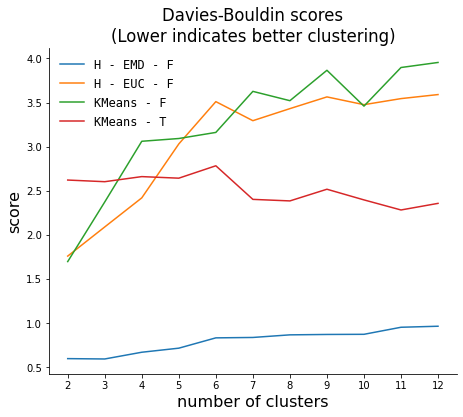

In [48]:
db_scores = \
{
    'H - EMD - F': list(get_db_emd_fdata(plot=False).values()),
    'H - EUC - F': list(get_db_euc_fdata(plot=False).values()),
    'KMeans - F':       list(get_db_km_fdata(plot=False).values()),
    'KMeans - T':       list(get_db_km_tdata(plot=False).values())
}

fig = plt.figure(figsize=(7.3, 6))
ax = plt.subplot(111)

for method, scores in db_scores.items():
    plt.plot(scores, label=method)

plt.title("Davies-Bouldin scores\n(Lower indicates better clustering)", fontdict={'size': 16.5})

leg = ax.legend(prop={'family': 'monospace', 'size': 12}, frameon=False)
plt.xticks(range(len(cluster_range)), list(cluster_range))
plt.ylabel("score", fontdict={'size': 16})
plt.xlabel("number of clusters", fontdict={'size': 16})

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# fig.savefig(
#     '/home/kushal/Sars_stuff/Dropbox/fig_data/compare_clustering_method_scores/db_scores.png',
#     dpi=600,
#     pad_inches=0,
#     bbox_inches='tight'
# )

plt.show()